# <font size=35 color=lightgreen>** Sentiment API **<font>
---

### <font size=12 color=lightgreen>Configuración Inicial (Librerías)</font>

#### 1. Procesamiento y Manipulación de Datos
* **`pandas`**
    * Nos ayuda con la manipulación y análisis de datos estructurados.
    * Carga el dataset (CSV), gestiona el DataFrame y permite filtrar o limpiar registros.
* **`numpy`**
    * Realiza las operaciones matemáticas y manejo de arrays eficientes.
    * Soporte numérico fundamental para las transformaciones vectoriales de los textos.

#### 2. Visualización y Análisis Exploratorio

* **`matplotlib.pyplot`**
    * Generación de gráficos estáticos.
    * Visualización básica de la distribución de clases (Positivo vs. Negativo).
* **`seaborn`**
    * Visualización de datos estadísticos avanzada.
    * Generación de matrices de confusión y gráficos de distribución estéticos para la presentación.

#### 3. Procesamiento de Lenguaje Natural (NLP) y Limpieza

* **`re`** (Regular Expressions)
    * Manejo de expresiones regulares.
    * Eliminación de ruido en el texto: URLs, menciones (@usuario), hashtags (#) y caracteres especiales no alfanuméricos.
* **`string`**
    * Constantes de cadenas comunes.
    * Provee listas estándar de signos de puntuación para su eliminación eficiente.

#### 4. Modelado y Machine Learning (Core)

* **`scikit-learn`**
    * Biblioteca principal de Machine Learning.
    * **`TfidfVectorizer`**: Transforma el texto limpio en vectores numéricos.
    * **`LogisticRegression`**: Algoritmo de clasificación supervisada.
    * **`metrics`**: Cálculo de precisión, recall y F1-score.
    * **`Pipeline`**: Encapsulamiento de los pasos de transformación y predicción.

#### 5. Persistencia e Integración
Herramientas para conectar el modelo con el Backend.

* **`joblib`**
    * Serialización eficiente de objetos Python.
    * Exportar (`dump`) el pipeline entrenado a un archivo `.joblib` y cargarlo (`load`) en la API para realizar predicciones.
* **`fastapi` & `uvicorn`**
    * Framework web moderno de alto rendimiento.
    * Exponer el modelo entrenado como un microservicio REST (endpoint `/predict`) para ser consumido por el Backend en Java.




---



### <font size=16  color=lightgreen> Importando librerías <font>



In [15]:
%pip install uvicorn
%pip install nltk
%pip install fastapi
%pip install scikit-learn
%pip install joblib

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import chardet
import uvicorn
import sklearn
import fastapi
import joblib
import nltk
import unicodedata
import chardet
import urllib.request
import io
import urllib.response
import warnings
from io import StringIO
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


### <font size = 8 color="lightgreen">Importación de los datasets<font>

#### **Función importación dataset**

In [16]:
def importar_dataset(url):
    """
    Importa dataset desde URL detectando encoding automáticamente.
    """
    try:
        # 1. Descargar contenido una sola vez
        with urllib.request.urlopen(url) as response:
            content = response.read()
        
        # 2. Detectar encoding
        result = chardet.detect(content)
        encoding = result['encoding']
        print(f"🔍 Encoding detectado: {encoding} (confianza: {result['confidence']:.2%})")
        
        # 3. Decodificar y cargar en DataFrame
        decoded_content = content.decode(encoding, errors='replace')
        data = pd.read_csv(StringIO(decoded_content), sep=';')
        
        print("✅ Archivo cargado correctamente")
        print(f"📊 Tamaño del dataset: {data.shape}")
        print("\n🔍 Muestra aleatoria (3 registros):")
        print(data.sample(3))
        
        return data
        
    except urllib.error.URLError as e:
        print(f"❌ Error de URL: {e}")
        return None
    except pd.errors.ParserError as e:
        print(f"❌ Error al parsear CSV: {e}")
        return None
    except Exception as e:
        print(f"❌ Error inesperado: {type(e).__name__}: {e}")
        return None

#### **Dataset1: sentimentdataset_es.csv**

In [17]:
data1 = importar_dataset("https://raw.githubusercontent.com/ml-punto-tech/sentiment-api/refs/heads/feature/data-science-marely/data-science/datasets/datasets-origin/sentimentdataset_es.csv")


🔍 Encoding detectado: utf-8 (confianza: 99.00%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (732, 15)

🔍 Muestra aleatoria (3 registros):
     Unnamed: 0.1  Unnamed: 0  \
65            646         650   
112            69          71   
172           288         292   

                                                  Text     Sentiment  \
65   Inició un club de fotografía en la escuela.¡Ca...       Alegría   
112  Anticipando una emocionante aventura en las pr...  Anticipación   
172  Pasos confiados en la danza de la vida, un sal...      Confiado   

            Timestamp                 User   Platform  \
65   04-08-2023 16:30  PhotoClubHighSchool  Instagram   
112   17-02-2023 7:30      AdventureAwaits  Instagram   
172  15-01-2021 13:00         DanceStrider   Facebook   

                                     Hashtags  Retweets  Likes Country  Year  \
65   #ClubDeFotografía #FotógrafoDeSecundaria        22     45   EE.UU  2023   
112                   #Anticipación #Aven

#### **Dataset2: sentiment_analysis_dataset.csv**

In [18]:
data2 = importar_dataset("https://raw.githubusercontent.com/ml-punto-tech/sentiment-api/refs/heads/feature/data-science-marely/data-science/datasets/datasets-origin/sentiment_analysis_dataset.csv")

🔍 Encoding detectado: Windows-1252 (confianza: 73.00%)
✅ Archivo cargado correctamente
📊 Tamaño del dataset: (2540, 3)

🔍 Muestra aleatoria (3 registros):
                                                  texto  label sentimiento
2443  A ver, si tan valiente te reto a etiquetar a l...      2    positivo
2413  Cada media hora abro los diarios ..esperanzado...      2    positivo
1278  Es tan irónica la vida, mi trabajo radica en s...      2    positivo


### <font size= 12 color="lightgreen" >Explorando los datasets<font>

In [19]:
# Crear función para explorar datasets
def explorar_dataset(data):
    print('Filas: ' + str(data.shape[0]))
    print('Columnas: ' + str(data.shape[1]))
    print('\nColumnas: \n' + str(data.columns.tolist()))
    print('\nTipo de datos: \n' + str(data.dtypes))
    print('\nValores nulos: \n' + str(data.isnull().sum()))
    print(data.sample(3))

#### **Explorando Data1**

In [20]:
explorar_dataset(data1)

Filas: 732
Columnas: 15

Columnas: 
['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User', 'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day', 'Hour']

Tipo de datos: 
Unnamed: 0.1     int64
Unnamed: 0       int64
Text            object
Sentiment       object
Timestamp       object
User            object
Platform        object
Hashtags        object
Retweets         int64
Likes            int64
Country         object
Year             int64
Month            int64
Day              int64
Hour             int64
dtype: object

Valores nulos: 
Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64
     Unnamed: 0.1  Unnamed: 0  \
620           357         361   
84             98         100   
87             83          8

#### **Explorando data2**

In [21]:
explorar_dataset(data2)

Filas: 2540
Columnas: 3

Columnas: 
['texto', 'label', 'sentimiento']

Tipo de datos: 
texto          object
label           int64
sentimiento    object
dtype: object

Valores nulos: 
texto          0
label          0
sentimiento    0
dtype: int64
                                                  texto  label sentimiento
1236  Wjiwjw hoy cuando fui a la librería para compr...      2    positivo
747   Este año seré la persona más fría,egocéntrica ...      0    negativo
168   172. Si no eres mortificado nunca serás alma d...      0    negativo


### <font size=12 color=lightgreen>Limpiar textos</font>

#### **Función para limpieza de textos**

In [22]:
def pre_proccess_text(texto):
    """
    Normaliza texto español preservando ñ y eliminando tildes.
    NO convierte a minúsculas para preservar intensidad emocional.
    """
    if not isinstance(texto, str):
        return ""



    # ❌ ELIMINAR ESTA LÍNEA (o comentarla):
    # texto = texto.lower()  # ← ESTO ELIMINA INTENSIDAD EMOCIONAL

    # El resto de tu código está bien:
    texto = unicodedata.normalize('NFD', texto)
    texto = texto.replace('n\u0303', '@@@N_TILDE@@@')
    texto = texto.replace('ñ', '@@@N_TILDE@@@')
    texto = texto.replace('N\u0303', '@@@N_TILDE_MAYUS@@@')
    texto = texto.replace('Ñ', '@@@N_TILDE_MAYUS@@@')

    texto = ''.join(
        char for char in texto
        if not unicodedata.combining(char)
    )

    texto = texto.replace('@@@N_TILDE@@@', 'ñ')
    texto = texto.replace('@@@N_TILDE_MAYUS@@@', 'Ñ')

    # Limpieza básica (tu código)
    resultado = texto
    chars = []
    for char in resultado:
        if char.isprintable():
            chars.append(char)
        else:
            chars.append(' ')
    resultado = ''.join(chars)

    resultado = re.sub(r'https?://[^\s]*\.\.\.', '[URL_ROTA]', resultado)
    resultado = re.sub(r'www\.[^\s]*\.\.\.', '[URL_ROTA]', resultado)
    resultado = ' '.join(resultado.split())
    resultado = resultado.strip()

    return resultado

#### **Limpieza Data1**

In [23]:
#Llamar a la función pre_proccess_text
data1['Texto_Limpio'] = data1['Text'].apply(pre_proccess_text)
print(data1[['Text','Texto_Limpio']].sample(5))

                                                  Text  \
522  Colaborar en un proyecto escolar con sus compa...   
595       Sentirme inspirado tras asistir a un taller.   
644  Serenidad encontrada en las páginas de un libr...   
104  Ecos dolorosos de un amor una vez apreciado, a...   
11   Abrazar el flujo y reflujo de la vida, encontr...   

                                          Texto_Limpio  
522  Colaborar en un proyecto escolar con sus compa...  
595       Sentirme inspirado tras asistir a un taller.  
644  Serenidad encontrada en las paginas de un libr...  
104  Ecos dolorosos de un amor una vez apreciado, a...  
11   Abrazar el flujo y reflujo de la vida, encontr...  


#### **Limpieza Data2**

In [24]:
# Aplicar al DataFrame
data2['Texto_Limpio'] = data2['texto'].apply(pre_proccess_text)
data2['Sentimiento_Final'] = data2['sentimiento']

# Mostrar un ejemplo del antes y después
print(data2[['texto', 'Texto_Limpio']].sample(5))

                                                  texto  \
2367  Siempre me sensibilizó Terminator II cuando le...   
601   Toda la tarde haciendo la Fila Virtual para co...   
1421  Todo el día he pasado con ganas de comer mangu...   
1859  Si me costaba ser abierta o quizás desenvolver...   
319   No le hagan comentarios a la gente ansiosa por...   

                                           Texto_Limpio  
2367  Siempre me sensibilizo Terminator II cuando le...  
601   Toda la tarde haciendo la Fila Virtual para co...  
1421  Todo el dia he pasado con ganas de comer mangu...  
1859  Si me costaba ser abierta o quizas desenvolver...  
319   No le hagan comentarios a la gente ansiosa por...  


### <font size=12 color=lightgreen> Categorizar sentimientos </font>

In [25]:
# 1. Definimos las listas de sentimientos según su categoría
# Ver todos los sentimientos únicos para saber qué agrupar
print(data1['Sentiment'].unique())


['Abrumado' 'Aburrimiento' 'Aceptación' 'Admiración' 'Adoración'
 'Adrenalina' 'Afecto' 'Agotamiento' 'Agradecido' 'Agridulce'
 'Aislamiento' 'Alegría' 'Alegría al hornear' 'Alegría festiva'
 'Alegría juguetona' 'Alivio' 'Amabilidad' 'Amable' 'Amar' 'Amargura'
 'Ambivalencia' 'Amistad' 'Amor perdido' 'Angustia' 'Anhelo' 'Ánimo'
 'Ansiedad' 'Anticipación' 'Apreciación' 'Aprensivo' 'Armonía'
 'Arrepentimiento' 'Asco' 'Asombro' 'Aventura' 'Aventura Culinaria'
 'Bendición' 'Cálculo erróneo' 'Calma' 'Capricho' 'Cautivación'
 'Cazador de sueños' 'Celebración' 'Celos' 'Celoso' 'Chispa' 'Colorido'
 'Comodidad' 'Compasión' 'Compasivo' 'Compromiso' 'Conexión' 'Confiado'
 'Confianza' 'Confusión' 'Consciencia' 'Consuelo' 'Contemplación'
 'Contentamiento' 'Creatividad' 'Creatividad de la pasarela'
 'Cumplimiento' 'Curiosidad' 'De espíritu libre' 'Decepción' 'Desafío'
 'Desamor' 'Descubrimiento' 'Desesperación' 'Deslumbrar' 'Despectivo'
 'Determinación' 'Devastado' 'Disfrute' 'Diversión' 'Dolor' 'El

In [26]:
# 1. SENTIMIENTOS POSITIVOS (Bienestar, éxito, alegría)
positivos = [
    'Aceptacion', 'Admiracion', 'Adoracion', 'Adrenalina', 'Afecto', 'Agradecido',
    'Alegria', 'Alegria al hornear', 'Alegria festiva', 'Alegria juguetona', 'Alivio',
    'Amabilidad', 'Amable', 'Amar', 'Amistad', 'Animo', 'Apreciacion', 'Armonia',
    'Asombro', 'Aventura', 'Aventura culinaria', 'Bendicion', 'Calma', 'Capricho',
    'Cautivacion', 'Cazador de suenos', 'Celebracion', 'Chispa', 'Colorido', 'Comodidad',
    'Compasion', 'Compasivo', 'Compromiso', 'Conexion', 'Confiado', 'Confianza',
    'Consciencia', 'Consuelo', 'Contentamiento', 'Creatividad', 'Creatividad de la pasarela',
    'Cumplimiento', 'De espiritu libre', 'Descubrimiento', 'Deslumbrar', 'Determinacion',
    'Disfrute', 'Diversion', 'Elacion', 'Elegancia', 'Emocion', 'Emocionado', 'Empatico',
    'Empoderamiento', 'Encantamiento', 'Encanto', 'Energia', 'Entusiasmo', 'Esfuerzo renovado',
    'Esperanza', 'Euforia', 'Excitacion', 'Exito', 'Exploracion', 'Explosion artistica',
    'Extasis', 'Fascinante', 'Felicidad', 'Feliz', 'Grandeza', 'Gratitud', 'Hipnotico',
    'Iconico', 'Imaginacion', 'Inmersion', 'Inspiracion', 'Inspiracion creativa', 'Inspirado',
    'Intriga', 'Jugueton', 'La belleza de la naturaleza', 'La libertad del oceano', 'Libertad',
    'Lleno de alegria', 'Logro', 'Magia de invierno', 'Maravilla', 'Maravilla celestial',
    'Melodico', 'Motivacion', 'Optimismo', 'Orgullo', 'Orgulloso', 'Positividad', 'Positivo',
    'Reconfortante', 'Rejuvenecimiento', 'Resiliencia', 'Resplandor', 'Reunion alegre',
    'Reverencia', 'Romance', 'Satisfaccion', 'Serenidad', 'Tranquilidad', 'Triunfo',
    'Vibrancia', 'Viaje emocionante'
]


# 2. SENTIMIENTOS NEGATIVOS (Dolor, ira, miedo, estrés)
negativos = [
    'Abrumado', 'Aburrimiento', 'Agotamiento', 'Agridulce', 'Aislamiento', 'Amargura',
    'Amor perdido', 'Angustia', 'Anhelo', 'Ansiedad', 'Aprensivo', 'Arrepentimiento',
    'Asco', 'Celos', 'Celoso', 'Decepcion', 'Desafio', 'Desamor', 'Desesperacion',
    'Despectivo', 'Devastado', 'Dolor', 'Enojo', 'Entumecimiento', 'Envidia', 'Envidiar',
    'Envidioso', 'Frustracion', 'Frustrado', 'Impotencia', 'Intimidacion', 'Lastima',
    'Malo', 'Melancolia', 'Miedo', 'Negativo', 'Obstaculo', 'Odiar', 'Oscuridad', 'Pena',
    'Perdida', 'Presion', 'Resentimiento', 'Soledad', 'Sufrimiento', 'Temeroso', 'Temor',
    'Tormenta emocional', 'Traicion', 'Tristeza', 'Tristezaza', 'Verguenza'
]

# 3. SENTIMIENTOS NEUTRALES (O "Grises" que no definen éxito/fracaso)
# Aquí incluimos "Confuso" (Blender) y otros estados contemplativos
neutros = [
    'Ambivalencia', 'Anticipacion', 'Calculo erroneo', 'Confusion', 'Confuso',
    'Contemplacion', 'Curiosidad', 'Indiferencia', 'Neutral', 'Nostalgia',
    'Odisea culinaria', 'Pensive', 'Preguntarse', 'Reflexion', 'Restos',
    'Suspenso', 'Susurros del pasado', 'Travieso', 'Viaje', 'Viaje interior',
    'Visualizando la historia'
]

#### **Función para categorizar sentimientos**

In [27]:
def categorizar_sentimiento(sentimiento):
    # Limpiamos espacios en blanco y estandarizamos a título
    sent = str(sentimiento).strip().title()

    if sent in positivos:
        return 'positivo'
    elif sent in negativos:
        return 'negativo'
    else:
        # Por defecto, lo que no conocemos o es ambiguo va a Neutral para el MVP
        return 'neutral'


In [28]:
# 2. Aplicamos la función a tu columna 'Sentimiento'
data1['Sentimiento_Final'] = data1['Sentiment'].apply(categorizar_sentimiento)

In [29]:
data1.head()

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour,Texto_Limpio,Sentimiento_Final
0,303,307,"Abrumado por el peso del mundo, Atlas con los ...",Abrumado,25-06-2021 17:50,AtlasBearer,Instagram,#Abrumado #BouldersOfExhaustion,22,44,Canadá,2021,6,25,17,"Abrumado por el peso del mundo, Atlas con los ...",negativo
1,313,317,"Abrumado por la cacofonía de las expectativas,...",Abrumado,29-11-2021 8:45,TempestSurvivor,Facebook,#Abrumado #AhogandoAlma,20,40,EE.UU,2021,11,29,8,"Abrumado por la cacofonia de las expectativas,...",negativo
2,325,329,"Abrumado por el laberinto de expectativas, un ...",Abrumado,22-02-2020 15:20,MazeExplorer,Facebook,#Abrumado #MinotauroDePresión,22,44,EE.UU,2020,2,22,15,"Abrumado por el laberinto de expectativas, un ...",negativo
3,338,342,Abrumado por el apoyo recibido durante un desa...,Abrumado,20-05-2021 17:30,PersonalJourney,Facebook,#Overwhelmed #SupportiveCommunity,25,50,EE.UU,2021,5,20,17,Abrumado por el apoyo recibido durante un desa...,negativo
4,170,172,"Llega el aburrimiento, el día se siente infini...",Aburrimiento,28-09-2016 19:45,BoredMind,Twitter,#Aburrimiento #FaltaDeInterés,8,15,Canadá,2016,9,28,19,"Llega el aburrimiento, el dia se siente infini...",negativo


### <font size=12 color=lightgreen> Filtrar dataset </font>

In [30]:
# Función filtrar dataset
def filtrar_dataset(data):
  data_filtrada = data[['Texto_Limpio', 'Sentimiento_Final']]
  data_filtrada = data_filtrada[data_filtrada['Texto_Limpio'].str.strip() != ""]
  print(data_filtrada.sample(5))
  print()
  print('Distribución de Sentimiento')
  print(data_filtrada['Sentimiento_Final'].value_counts())
  return data_filtrada


#### **Creando dataframe filtrado Data1**

In [31]:
data1_filtrado = filtrar_dataset(data1)

                                          Texto_Limpio Sentimiento_Final
280  En la sinfonia del dolor, cada lagrima es una ...          negativo
359   Despertar de entusiasmo por un proximo festival.           neutral
8    Encontrar aceptacion en medio de los desafios ...           neutral
713  Sentir una sensacion de vacio despues de que u...          negativo
649  Disfrutando de la serenidad de un bosque tranq...          positivo

Distribución de Sentimiento
Sentimiento_Final
neutral     330
positivo    250
negativo    152
Name: count, dtype: int64


#### **Creando dataframe filtrado Data2**

In [32]:
data2_filtrado = filtrar_dataset(data2)

                                           Texto_Limpio Sentimiento_Final
324   me fui a cocinar, volvi, y a bauti, lo habia p...          negativo
1051  Tengo antojo inmenso de algo pero me da mil fl...          negativo
153   q incomodo es ver una pelicula con tu familia ...          negativo
2491  —Hasta que me muera. Encogio los hombros, desp...          positivo
680   ¿Crepusculo lejano?? Dos extremos en la tabla....          negativo

Distribución de Sentimiento
Sentimiento_Final
negativo    1148
positivo     981
neutral      411
Name: count, dtype: int64


### <font size=12 color=lightgreen> Unificar y exportar </font>

In [33]:
# Función para preparar datasets para unificación

def preparar_unificacion(data):
  data = data[['Texto_Limpio', 'Sentimiento_Final']]
  data = data[data['Texto_Limpio'].str.strip() != ""]
  data_clean = data[data['Sentimiento_Final'].notna()]
  print(data.sample(5))
  return data

#### **Preparación para unificar Data1**


In [34]:
data1_clean = preparar_unificacion(data1_filtrado)


                                          Texto_Limpio Sentimiento_Final
513   La Tristezaza invernal me hizo sentir deprimido.          negativo
36   Bailando bajo el sol, cada paso es una celebra...           neutral
442  Al reflexionar sobre toda una vida de recuerdo...          positivo
708  Reflexionando sobre los desafios del año escol...          negativo
649  Disfrutando de la serenidad de un bosque tranq...          positivo


#### **Preparación para unificar Data2**

In [35]:
data2_clean = preparar_unificacion(data2_filtrado)

                                           Texto_Limpio Sentimiento_Final
1626  Cuando "Butch" debuto en el roster principal e...          positivo
2158  Le quiero dar un abrazo a mi desesperacion e i...           neutral
886     que mierdisima que a las 6pm ya este obscuro ??          negativo
421   Despues de varios comentarios agrios y hate re...          negativo
797   Como me cae gordo el Akihiko, nomas me puse a ...          negativo


#### **Creando exportable**

In [36]:
# ignore_index=True es fundamental para que el índice sea correlativo del 0 al total
df_unificado = pd.concat([data1_clean, data2_clean], ignore_index=True)

# 2. Mostrar información del nuevo dataset
print(f"Registros en dataset 1: {len(data1_clean)}")
print(f"Registros en dataset 2: {len(data2_clean)}")
print(f"Total de registros unificados: {len(df_unificado)}")

# 3. Vista previa
df_unificado.head()

Registros en dataset 1: 732
Registros en dataset 2: 2540
Total de registros unificados: 3272


,Texto_Limpio,Sentimiento_Final
0,"Abrumado por el peso del mundo, Atlas con los ...",negativo
1,"Abrumado por la cacofonia de las expectativas,...",negativo
2,"Abrumado por el laberinto de expectativas, un ...",negativo
3,Abrumado por el apoyo recibido durante un desa...,negativo
4,"Llega el aburrimiento, el dia se siente infini...",negativo


#### **Visualizar distribución de sentimientos de data exportable**

<bound method Series.sort_values of Sentimiento_Final
negativo    1300
positivo    1231
neutral      741
Name: count, dtype: int64>


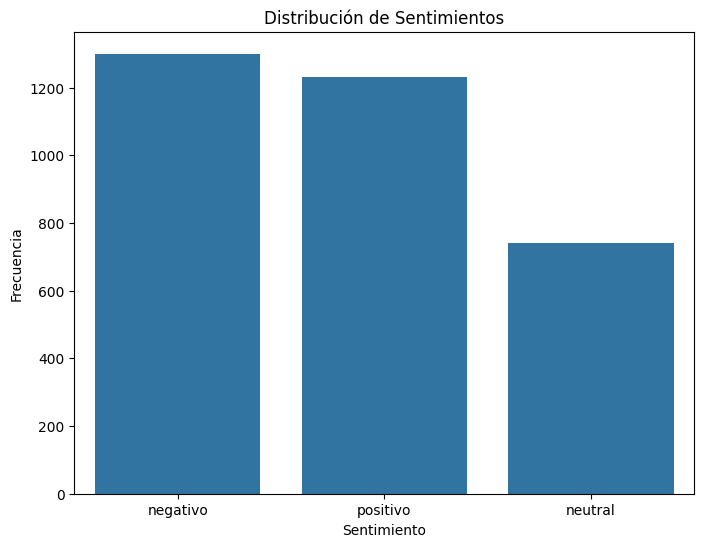

In [37]:

# Distribución de los sentimientos
print(df_unificado['Sentimiento_Final'].value_counts().sort_values)
# Gráfico Distribución de sentimientos del df_unificado ordenado descendente columnas
plt.figure(figsize=(8, 6))
sns.countplot(data=df_unificado, x='Sentimiento_Final', order=df_unificado['Sentimiento_Final'].value_counts().index)
plt.title('Distribución de Sentimientos')
plt.xlabel('Sentimiento')
plt.ylabel('Frecuencia')
plt.show()


#### **Exportar df_unificado a csv**


In [41]:
import os


# Exportar el dataset
df_unificado.to_csv('data-science\datasets\dataset_listo_para_ML.csv', index=False)

print("Dataset exportado exitosamente.")



Dataset exportado exitosamente.


---
### <font size=12 color=lightgreen>Observaciones</font>


### 1. **<font color='lightgreen'>Origen de los datos</font>**

Con el objetivo de mejorar la capacidad de generalización del modelo, se trabajó con dos datasets independientes obtenidos desde Kaggle.
Si bien ambos conjuntos de datos abordan el análisis de sentimiento en español, presentan diferencias en estructura, calidad lingüística y formato de origen. Su integración permitió ampliar la diversidad de expresiones textuales, reduciendo el sesgo hacia un único estilo de redacción y fortaleciendo la robustez del pipeline de preparación de datos en escenarios similares a producción.

#### **Fuentes de datos (Kaggle):**

https://www.kaggle.com/datasets/engineercolsoquas/spanish-sentiment-analysis-dataset

https://www.kaggle.com/datasets/kashishparmar02/social-media-sentiments-analysis-dataset


---
### 2. **<font color='lightgreen'> Informe de Desafíos Técnicos y Soluciones</font>**

#### **Dataset** 1 – Inconsistencias en el idioma

- Problema: El dataset original presentaba traducciones incompletas, combinando registros en español con fragmentos en su idioma original, además de traducciones literales de baja calidad. Esta situación afectaba la coherencia semántica del texto y podía introducir ruido en el análisis de sentimiento.

- Solución aplicada: Se utilizó la herramienta de Traducción de Microsoft Excel como apoyo para identificar registros no traducidos. No obstante, la corrección se realizó de forma manual y supervisada, revisando y ajustando cada registro individualmente con el fin de preservar el significado original del texto y evitar distorsiones semánticas. Posteriormente, se realizó una revisión manual (sanity check) para asegurar la consistencia lingüística del dataset completo.

- Impacto en el análisis: La normalización del idioma permitió obtener un corpus coherente en español, reduciendo ambigüedades y mejorando la calidad de los datos de entrada para la etapa de clasificación de sentimiento.


**Dataset 2 – Problemas de codificación de caracteres (encoding)**

- Problema:
El segundo dataset se encontraba en formato Excel y presentaba errores de codificación al ser abierto, evidenciados por la aparición de caracteres especiales incorrectos (mojibake), lo que impedía un procesamiento adecuado del texto.

- Solución aplicada:
Como primer paso, el archivo fue exportado a formato CSV. Posteriormente, se realizó la ingesta mediante Power Query, donde se configuró explícitamente la codificación Unicode (UTF-8), corrigiendo la estructura de caracteres antes de su integración al pipeline de preparación de datos.

- Impacto en el análisis:
La corrección del encoding aseguró la correcta interpretación de caracteres propios del idioma español, evitando pérdidas de información y mejorando la calidad del texto procesado.
---


### 3. **<font color='lightgreen'>Normalización y Limpieza de Texto</font>**
- Se aplicó una función de preprocesamiento (pre_proccess_text) que incluyó:

- Preservación de mayúsculas/minúsculas (para mantener intensidad emocional).

- Eliminación de tildes (pero conservación de ñ/Ñ).

- Limpieza de URLs, menciones y caracteres no imprimibles.

- Normalización de espacios y saltos de línea.

**Nota: Se decidió no convertir todo a minúsculas para conservar pistas contextuales (ej. “¡GENIAL!” vs. “genial”), relevantes para modelos basados en intensidad emocional.**

---

### 4. <font color='lightgreen'>Categorización de Sentimientos</font>
Dado que el Dataset 1 contenía 182 sentimientos diferentes, se definió un esquema de agrupación en tres categorías:

Categoría	Ejemplos de Sentimientos Incluidos

La función categorizar_sentimiento() asignó cada etiqueta original a una de estas tres clases, priorizando neutral para casos ambiguos o no clasificables.

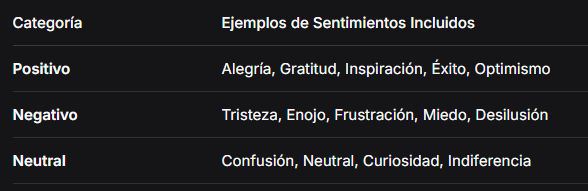

---
### 5. **<font color='lightgreen'>Estructura final de Dataset Unificado</font>**

El dataset exportado (dataset_listo_para_ML.csv) contiene:

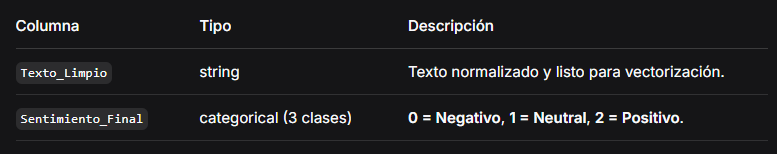


Estadísticas finales:

Registros totales: 3,272

Distribución:

- Negativo: 1,300 (39.7%)

- Positivo: 1,231 (37.6%)

- Neutral: 741 (22.7%)
---